#### Imports

In [1]:
import mne      # toolbox for analyzing and visualizing EEG data
import os       # using operating system dependent functionality (folders)
import pandas   # data analysis and manipulation
import numpy    # numerical computing (manipulating and performing operations on arrays of data)
import copy     # Can Copy and Deepcopy files so original file is untouched.

from IPython.display import clear_output
import warnings

#### Load Metadata files

Change 'originalPATH' to path where Metadata files are located (and 'excelPATH' to save location of excel files).

In [2]:
# VARIABLES:
PATH_metadata = "D:\\EEG Data\\New Dataset\\Metadata\\"
PATH_excelFiles = "D:\\EEG Data\\New Dataset\\Excel Files\\"
MakeExcelFiles = True # Option to put .txt files into Excel files

def LoadMetaData(filename):
    originalPATH = PATH_metadata + filename + '.txt'    
    if os.path.exists(originalPATH):  
        MetaData = pandas.read_table(originalPATH)
        if(MakeExcelFiles):
            excelPATH = PATH_excelFiles + filename + '.xlsx'       
            MetaData.to_excel(excelPATH)            
        return MetaData            
    else: 
        print("PATH NOT FOUND:  " + originalPATH) 
        return None

cdi = LoadMetaData("cdi")
children = LoadMetaData("children")
parents = LoadMetaData("parents")

# Process Sound Event Codes file
CODES_overview = LoadMetaData("CODES_overview")
CODES_overview = CODES_overview.set_index("nrInPresentationScript")[["condition", "stimulusType", "nrOfToken"]]

## UNCOMMENT TO SHOW (one at a time) (shortcut: ctrl+/): 
# cdi
# children
# parents
CODES_overview

,condition,stimulusType,nrOfToken
nrInPresentationScript,,,
1,giepMultiple,standard1,1
2,giepMultiple,standard1,2
3,giepMultiple,standard1,3
4,giepMultiple,standard1,4
5,giepMultiple,standard1,5
...,...,...,...
71,gopMultiple,deviant,11
72,gopMultiple,deviant,12
104,gopSingle,standard1,1


#### Load EEG files
Change os.walk(PATH) to path where the Dataset is located. 

In [3]:
EEG = []
EEG_filenames = []
EEG_filelocation = []

for root, dirs, files in os.walk("D:\\EEG Data\\New Dataset\\Dataset\\"):
    for file in files:
        if file.endswith('.bdf') and len(file) == 8:
            BdfFile = mne.io.read_raw_bdf(root+'\\'+file)
            EEG.append(BdfFile)              
            EEG_filenames.append(file.replace(".bdf", ""))
            EEG_filelocation.append(root+'\\'+file)
            clear_output(wait=True)            
print(len(EEG), "EEG files loaded")

SHOW_EEG_INFO = True
if(SHOW_EEG_INFO):
    index = 7
    print('File Location: ',EEG_filelocation[index],'\n')
    print(EEG[index],'\n')
    print(EEG[index].info)

119 EEG files loaded
File Location:  D:\EEG Data\New Dataset\Dataset\104\104b\104b.bdf 

<RawEDF | 104b.bdf, 41 x 3794944 (1853.0 s), ~44 kB, data not loaded> 

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF3, F7, F3, FC1, FC5, T7, C3, CP1, CP5, P7, P3, Pz, PO3, ...
 chs: 40 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 417.0 Hz
 meas_date: 2021-06-11 09:31:48 UTC
 nchan: 41
 projs: []
 sfreq: 2048.0 Hz
>


#### Find Event markers

Events are saved and loaded externally from .txt file, since loading events from raw EEG file takes much longer.
If the event markers are not on your disk: Make a folder to store the event markers and uncomment the SAVE code.

In [4]:
## SAVE Event Markers to external .txt files:
# for i in range(len(EEG)):
#     numpy.savetxt("./Event Markers\\" + EEG_filenames[i] + ".txt", mne.find_events(EEG[i]), fmt = '%i')
#     clear_output(wait=True)

## LOAD Event Markers:
Events = [] 
Events_12 = []
for i in range(len(EEG)):
    Events.append(numpy.loadtxt("./Event Markers\\" + EEG_filenames[i] + ".txt", dtype = int))        
print(len(Events), "Event Marker files loaded")

SHOW_EVENT_INFO = True
participantIndex = 5
eventIndex = 500
if(SHOW_EVENT_INFO):
    event_time = Events[participantIndex][eventIndex][0]
    event_ID = Events[participantIndex][eventIndex][2]    
    print("\nParticipant", participantIndex,"heard event ID:", event_ID, 
          "after", event_time/EEG[participantIndex].info['sfreq'], 'seconds', 
          'as the ' + str(eventIndex) + "'th event")    
    print("\nEvent ID:", event_ID, "\nCondition:", CODES_overview["condition"][event_ID], "\nStimulus Type:",
         CODES_overview["stimulusType"][event_ID], "\nToken nr:", CODES_overview["nrOfToken"][event_ID],"\n") 

119 Event Marker files loaded

Participant 5 heard event ID: 17 after 388.5009765625 seconds as the 500'th event

Event ID: 17 
Condition: giepMultiple 
Stimulus Type: standard2 
Token nr: 5 



#### Simplify Event Markers
Combine different pronounciations

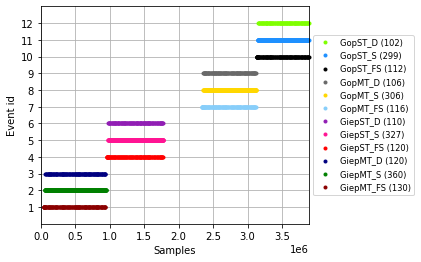

In [5]:
# M = Multiple / S = Single / T = Tokens            F = First / S = Standard / D = Deviant    
Dictionary = {'GiepMT_FS': 1, 'GiepMT_S': 2, 'GiepMT_D': 3,'GiepST_FS': 4, 'GiepST_S': 5, 'GiepST_D': 6,
             'GopMT_FS': 7, 'GopMT_S': 8, 'GopMT_D': 9, 'GopST_FS': 10, 'GopST_S': 11, 'GopST_D': 12}
EventConversion_12 = [[1,12,1],[13,24,2],[25,36,3],[101,101,4],[102,102,5],[103,103,6],
                      [37,48,7],[49,60,8],[61,72,9],[104,104,10],[105,105,11],[106,106,12]]

Events_12 = copy.deepcopy(Events)
for i in range(len(EEG)):
    for minOld,maxOld,newValue in EventConversion_12:
        Events_12[i] = numpy.where(numpy.logical_and(minOld<=Events_12[i] , Events_12[i]<=maxOld), newValue, Events_12[i])
        
colorDict =  {1:"#8b0000", 2:"#008000",3:"#000080",4:"#ff0000",5:"#ff1493",6:"#911eb4",7:"#87cefa",8:"#ffd700",9:"#696969",10:"#000000",11:"#1e90ff",12:"#7fff00"}
fig = mne.viz.plot_events(Events_12[4], event_id = Dictionary,color=colorDict)

#### Plot EEG
Install dependencies if tool for external window %matplotlib qt doesn't work.

Using matplotlib as 2D backend.


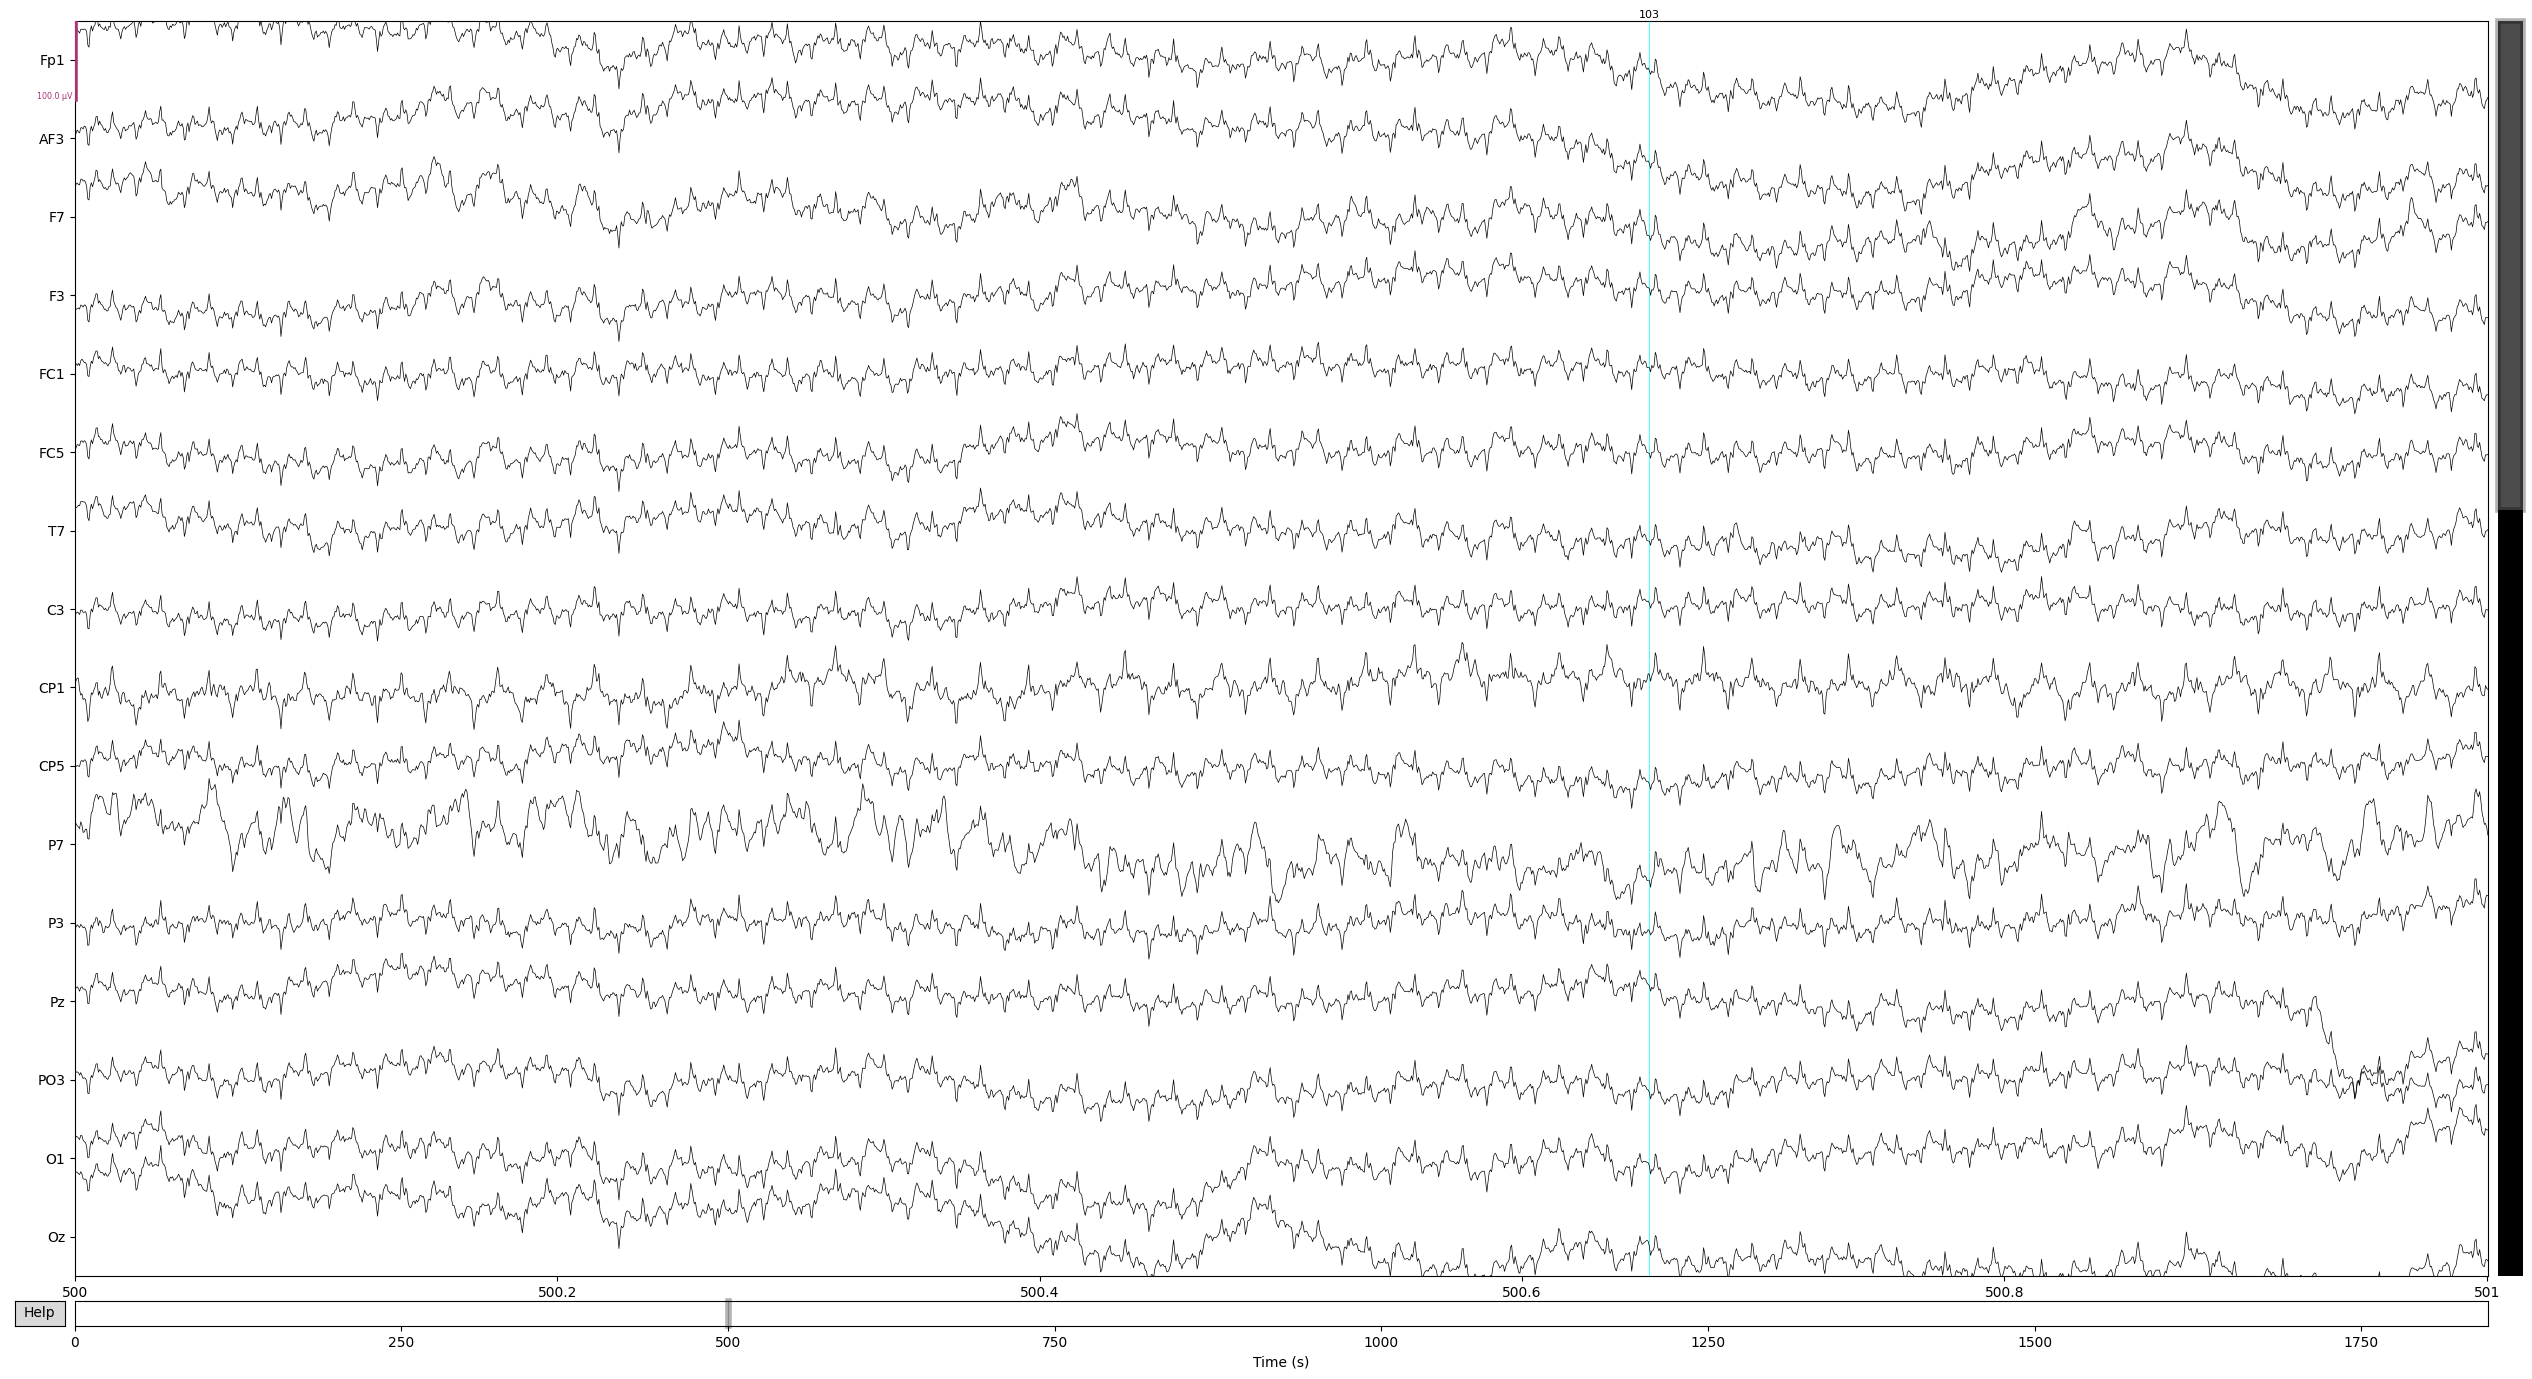

In [6]:
index = 3
%matplotlib qt 
mne.viz.plot_raw(EEG[index], events = Events[index],n_channels=16, scalings = 50e-6  ,duration = 1, start = 500)

In [7]:
# TDOO: MAKE ERPs
# TODO: Apply Deep learning
# TODO: Apply Pre-processing + Traditional ML